In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree
import graphviz
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorsys
import json

In [2]:
presentation_mode = True
if presentation_mode:
    import warnings
    warnings.filterwarnings('ignore')
    mpl.rcParams.update({'font.size': 20})
    mpl.rcParams.update({'axes.labelsize': 20})
    mpl.rcParams.update({'text.usetex': False})

# Experiment 1: orange vs. brown.
This experiment aims to investigate the perception of orange and brown by both humans and by standard neural networks trained for image recogition.

Human perception of orange and brown illustrates the phenomenon whereby knowing what light leave a surface is insufficient to determine the color of that surface; the light surrounding a surface also contributes to the experienced color. A light that is experienced as being orange when against a dim white background can change to seem brown when the background color becomes sufficiently bright.

Consider current neural networks used in image recognition: how capable are they of integrating surrounding color information to perceive orange or brown? Do they do this? If not, does it affect their performance? If so, can we say anything like "an aproximate X-dimensional euclidean space encodes most colors?". 

## Experiment 1.1.1
The first sub-experiment involves showing a human participant (me), using a monitor, a circle of a single color against a background of a single color. The participant then states what color they experience the circle to be. This is repeated many times, each time changing the color of the circle and the color of the background.

The aim of this experiment is two fold:

1. Check that we are capable of eliciting the orange/brown perceptual phenomenom.  
2. Gather some data that can be used to compare against data collected when testing neural networks (the latter method yet unknown).

### Setup
A simple web application was created to show a sequence of circles against backgrounds. Some screenshots:
![example 1](resources/circle_bg_1.png)
![example 2](resources/circle_bg_2.png)
![example 3](resources/circle_bg_3.png)
![example 4](resources/circle_bg_4.png)

The experiment didn't have very good controls. When I did the experiment, it was daytime and some of the light was coming through past the curtains. 

TODO: record monitor spec.
![experiment 1.1.1 setup](resources/experiment_1_1_1.jpg)

#### Data
Data comprises of the two colors (circle and background) and the answer. The answer has been split into 4 options.

In [13]:
data = pd.read_csv('./resources/experiment_1_1_1.csv')

The data looks like:

|  Answer  |  Circle Color    |  Background Color      |
| -------- | ---------------- | ---------------------- |
|  0  |  \[0.81, 0.75, 0.28\]   |  \[0.25, 0.25, 0.25\]  |
|  3  |  \[0.12, 0.15, 0.34\]   |  \[0.50, 0.50, 0.50\]     |
|  1  |  \[0.54, 0.23, 0.10\]  |  \[0.91, 0.91, 0.91\]  |
|  2  |  \[0.84, 0.19, 0.29\]   |  \[0.85, 0.85, 0.85\]  |
|  1  |  \[0.87, 0.34, 0.20\]   |  \[0.94, 0.94, 0.94\]  |
|  0  |  \[0.43, 0.43, 0.72\]  |  \[0.31, 0.31, 0.31\]  |

Where elements in the "Answer" represent my choice as follows:

| Answer | Meaning |
| ------ | --------|
| 0| orange   |
|1| brown  |
|2| both  |
|3| neither|  

The following shows the first few rows of the actual data:

In [4]:
# Preview
data[0:5]

,ans,circle_rgb,bg_rgb
0,3,"[1, 0, 0]","[0, 0, 0]"
1,3,"[0.24683667776828655, 0.21342619773353233, 0.2...","[0.9779460401490853, 0.9779460401490853, 0.977..."
2,3,"[0.113287755739501, 0.10473311081971061, 0.045...","[0.8183080537325035, 0.8183080537325035, 0.818..."
3,0,"[0.9795646896652704, 0.42022575630354925, 0.07...","[0.6902299453895665, 0.6902299453895665, 0.690..."
4,3,"[0.5693562687365206, 0.50516730506264, 0.18505...","[0.5103616563179266, 0.5103616563179266, 0.510..."


#### Circle and background color generation function
The first screen was red against black. What follows was a random selection of circle color and background color, with the conditions:

* The background colors are random colors between \[0, 0, 0\] and \[1, 1, 1\], with all elements kept equal. 
* The circle colors are chosen in HSV color space (Hue-Saturation-Value), where hue can vary between between 0.04-0.177, and saturation and value are randomly chosen between 0-1.

The following is the two functions used to create the colors:

In [5]:
HUE_RANGE = [0.04, 0.177]

def next_circle_rgb():
    hsv = [random.uniform(*HUE_RANGE), 
            random.random(),
            random.random()]
    rgb = colorsys.hsv_to_rgb(*hsv)
    return rgb


def next_bg_rgb():
    grey = random.random()
    return [grey, grey, grey]

Below, we flatten the color vectors (making each element a column). This is done as scikit-learn doesn't really work well when matrix elements are vectors.

In [6]:
# Serialize the data, to make using it with scikit-learn easier.
data_serial = pd.concat([pd.DataFrame([
    [row['ans'], *json.loads(row['circle_rgb']), *json.loads(row['bg_rgb'])]],
    columns=['ans', 'circle R', 'circle G', 'circle B', 'bg R', 'bg G', 'bg B'])
 for idx, row in data.iterrows()])
data_serial.head()

,ans,circle R,circle G,circle B,bg R,bg G,bg B
0,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,3,0.246837,0.213426,0.200337,0.977946,0.977946,0.977946
0,3,0.113288,0.104733,0.045887,0.818308,0.818308,0.818308
0,0,0.979565,0.420226,0.071191,0.690230,0.690230,0.690230
0,3,0.569356,0.505167,0.185052,0.510362,0.510362,0.510362


The below table shows the data types of each column. 

In [7]:
data_serial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ans       219 non-null    int64  
 1   circle R  219 non-null    float64
 2   circle G  219 non-null    float64
 3   circle B  219 non-null    float64
 4   bg R      219 non-null    float64
 5   bg G      219 non-null    float64
 6   bg B      219 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 13.7 KB


This next table shows some statistics. Nothing really interesting to see here.

In [8]:
data_serial.describe()

,ans,circle R,circle G,circle B,bg R,bg G,bg B
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,2.187215,0.522146,0.429388,0.262934,0.480307,0.480307,0.480307
std,1.221603,0.298772,0.267896,0.224879,0.285525,0.285525,0.285525
min,0.000000,0.001364,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.239660,0.197149,0.078438,0.221313,0.221313,0.221313
50%,3.000000,0.556740,0.410000,0.193327,0.512345,0.512345,0.512345
75%,3.000000,0.794788,0.657776,0.394948,0.718214,0.718214,0.718214
max,3.000000,1.000000,0.973452,0.952337,0.983227,0.983227,0.983227


#### Figure colors
The below figures will use a color scheme created in this section.

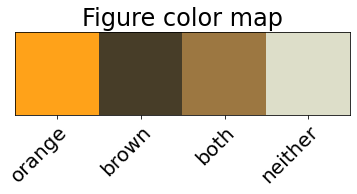

In [9]:
orange_marker_color = '#ffa219'
brown_marker_color = '#473d28'
both_marker_color = '#9c7741'
neither_marker_color = '#dddec9'
# orange, brown, both, neither
plot_colors = [orange_marker_color, brown_marker_color, both_marker_color, neither_marker_color]
color_list = [plot_colors[i] for i in data_serial.loc[:,'ans']]

colors_as_vec = [mpl.colors.to_rgb(c) for c in plot_colors ]
fig, ax = plt.subplots()
img = ax.imshow(np.array([colors_as_vec]))
# plt.gca().set_xticklabels(['a', 'b', 'c', 'd'])
ax.set_xticklabels(['orange', 'brown', 'both', 'neither'])
plt.xticks(np.arange(0, 4, 1.0))
ax.get_yaxis().set_visible(False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");
ax.set_title("Figure color map");

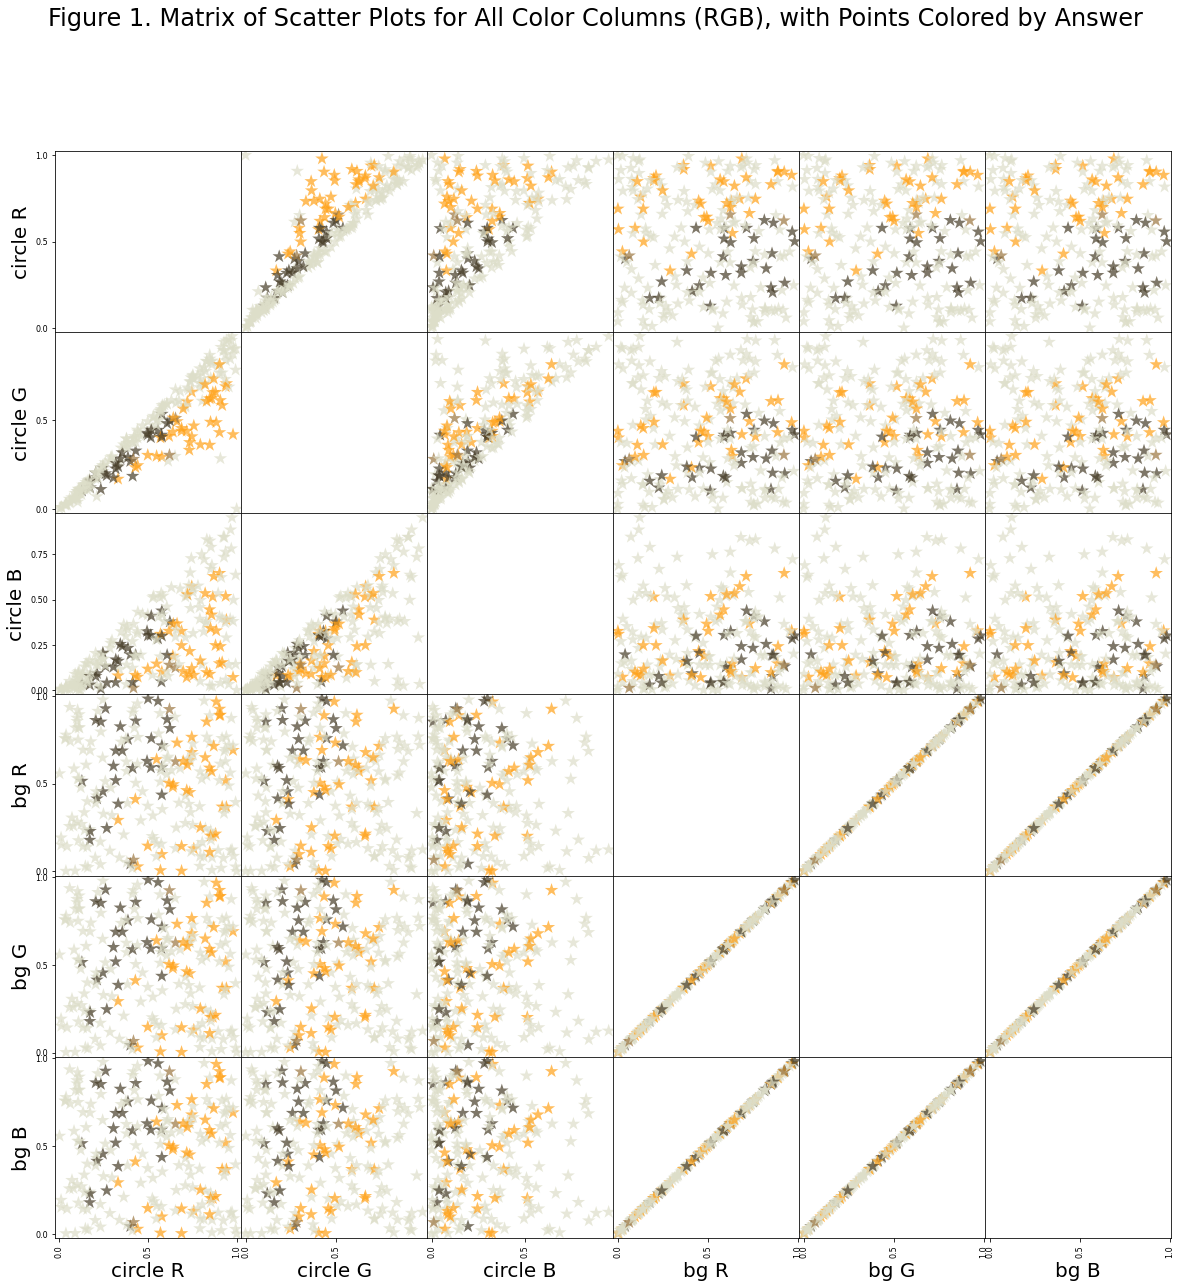

In [10]:
#### Figure 1: RGB scatter plots, colored by answer
ax1 = pd.plotting.scatter_matrix(data_serial.loc[:, data_serial.columns != 'ans'],
                          c=color_list,
                          figsize=[20,20],
                          diagonal=None,
                          alpha=0.7,
                          s=200,
                          marker='*')
ax1[0,0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
plt.suptitle('Figure 1. Matrix of Scatter Plots for All Color Columns (RGB), with Points Colored by Answer');
# Why is the title so far away?

#### Notes on figure 1
What I take away from figure 1 is that there isn't any single axis and there isn't any 2-axes pairs from the set (R,G,B) onto which we can project the data and draw a straight line to separate orange and brown. The best we can do is with the background blue vs. the circle red. But even with this, you must accept some false classifications. 

What does this mean more generally? Not a huge amount, I think. It's the next figure, which is more important.

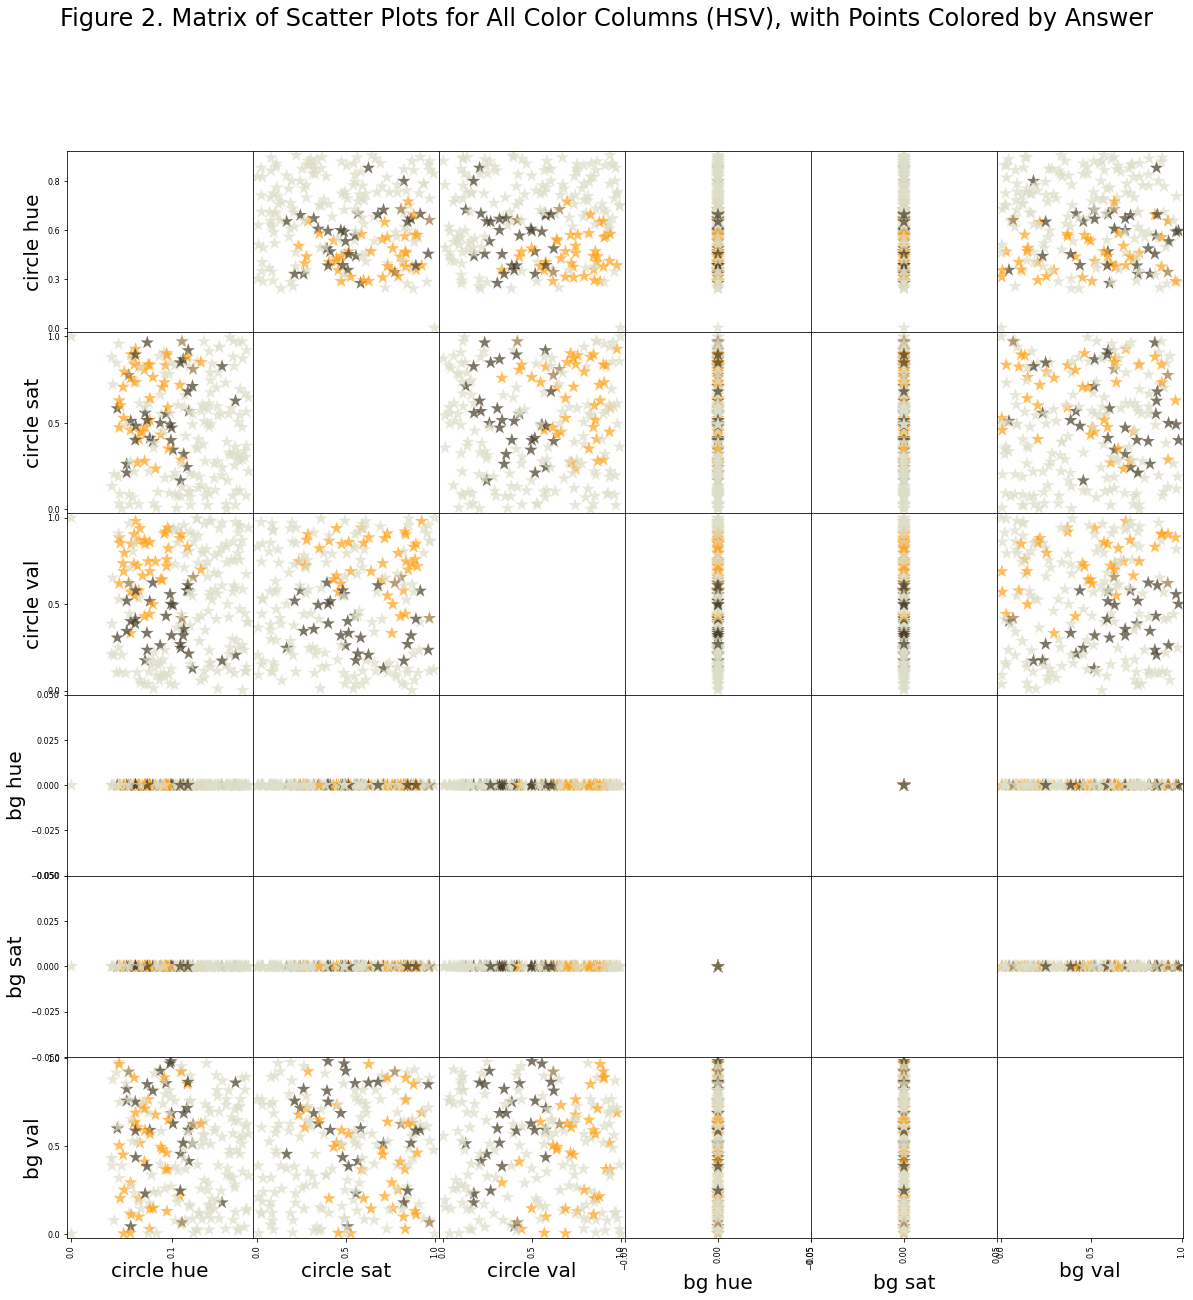

In [11]:
data_serial_hsv = pd.concat([pd.DataFrame([
    [row['ans'], *colorsys.rgb_to_hsv(*json.loads(row['circle_rgb'])), *colorsys.rgb_to_hsv(*json.loads(row['bg_rgb']))]],
    columns=['ans', 'circle hue', 'circle sat', 'circle val', 'bg hue', 'bg sat', 'bg val'])
 for idx, row in data.iterrows()])
ax2 = pd.plotting.scatter_matrix(data_serial_hsv.loc[:, data_serial_hsv.columns != 'ans'],
                          c=color_list,
                          figsize=[20,20],
                          #diagonal='hist',
                          diagonal=None,
                          alpha=0.7,
                          s=200,
                          marker='*')
plt.suptitle('Figure 2. Matrix of Scatter Plots for All Color Columns (HSV), with Points Colored by Answer');
ax2[0,0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

#### Notes on figure 2
Figure 2 suggests we have just recorded the phenomenon whereby orange transitions to brown based on comparative brightness with respect to surroundings. To see this, notice that the best two axes with which to separate the data is the circle value vs. background value. In other words, whether the circle appears orange or brown is depends on the brightness of the circle and the brightness of the background, and not so much on the hue or saturation of the circle or background.

### Remarks
Experiment 1.1.1 seems to capture the orange/brown phenomenon. Hopefully the data will be useful as a comparison.